In [1]:
#
!pip install --quiet --upgrade wrds pandas psycopg2-binary



import matplotlib.pyplot as plt
import pandas as pd, numpy as np, statsmodels.api as sm
from arch import arch_model
from scipy.stats import wilcoxon
import pandas as pd, os
from google.colab import files





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
Installed!  Runtime → Restart runtime, then re‑run your imports.


In [3]:


# Pick multiple files:
uploaded = files.upload()
uploaded = files.upload()
uploaded = files.upload()



KeyboardInterrupt: 

In [2]:


# ───── file paths in Colab workspace ─────
MASTER  = '/content/sp500_sector_master_1991_2025 true.csv'
CALCSV  = '/content/election_calendar.csv'
OUTPUT  = '/content/sp500_sector_master_elecSpecific.csv'

# ---------- ETF-code → column-prefix map (matches your _ret names) ----
ETF2SEC = {
    "XLE":"Energy",
    "XLB":"Materials",
    "XLI":"Industrials",
    "XLY":"ConsDiscr",
    "XLP":"ConsStaples",
    "XLV":"HealthCare",
    "XLF":"Financials",
    "XLK":"InfoTech",
    "XLC":"CommServices",
    "XLU":"Utilities",
    "XLRE":"RealEstate"
}

# ---------- 1. Load the two files ----------
df   = pd.read_csv(MASTER , parse_dates=['date'])
cal  = pd.read_csv(CALCSV, parse_dates=['call_date','inaug_date']).sort_values('call_date')

# ---------- 2. Detect sector tickers (plain prefixes) ----------
sector_cols = [c for c in df.columns
               if c.endswith('_ret') and c not in ('SPX_logret_ret','RF_log')]
tickers = [c.replace('_ret','') for c in sector_cols]

# ---------- 3. Remove any old CHI_ / D_ columns ----------
for pref in ('CHI_','D_'):
    df.drop(columns=[c for c in df.columns if c.startswith(pref)],
            inplace=True, errors='ignore')

# scaffold indicator columns
df['election'] = pd.NA
df['TRANS']    = 0
for t in tickers:
    df[f'CHI_{t}'] = 0
    df[f'D_{t}']   = 0

# ---------- 4. Populate election-specific flags ----------
for idx,row in cal.iterrows():
    start = row.call_date
    end   = cal.loc[idx+1, 'call_date'] - pd.Timedelta(days=1) if idx < len(cal)-1 else df['date'].max()
    mask_cycle = (df['date'] >= start) & (df['date'] <= end)
    df.loc[mask_cycle, 'election'] = row.election

    # translate ETF codes → sector prefixes that exist in the DataFrame
    treated = [ETF2SEC[x] for x in row.sectors.split('|')]
    for sec in treated:
        df.loc[mask_cycle, f'CHI_{sec}'] = 1

    mask_trans = (df['date'] > row.call_date) & (df['date'] <= row.inaug_date)
    df.loc[mask_trans, 'TRANS'] = 1

# ---------- 5. Create D_<sector> = TRANS * CHI_<sector> ----------
for t in tickers:
    df[f'D_{t}'] = df['TRANS'] * df[f'CHI_{t}']

# ---------- 6. Save & offer download ----------
df.to_csv(OUTPUT, index=False)
print(f"Election-specific dummy file saved to: {OUTPUT}")
files.download(OUTPUT)



FileNotFoundError: Upload both CSV files to /content/ before running.

In [7]:

#  COMPLETE PIPELINE

import subprocess, sys, warnings, os, math
def ensure(p):
    try: __import__(p)
    except ImportError:
        subprocess.check_call([sys.executable,"-m","pip","install",p,"--quiet"])
for p in ("pandas","numpy","statsmodels","arch","scipy","openpyxl"):
    ensure(p)
warnings.filterwarnings("ignore")



MASTER = "/content/sp500_sector_master_elecSpecific(2).csv"
CALCSV = "/content/election_calendar.csv"
XLSOUT = "/content/sp500_garch_output.xlsx"
if not (os.path.exists(MASTER) and os.path.exists(CALCSV)):
    raise FileNotFoundError("Upload sp500_sector_master_elecSpecific(2).csv and election_calendar.csv to /content/.")

# ── 1. Load data ─────────────────────────────────────────────
df  = pd.read_csv(MASTER,  parse_dates=["date"]).sort_values("date")
cal = pd.read_csv(CALCSV , parse_dates=["call_date","inaug_date"]).sort_values("call_date")

sector_cols = [c for c in df.columns if c.endswith("_ret")
               and c not in ("SPX_logret_ret","RF_log")]
sectors = [c.replace("_ret","") for c in sector_cols]

# ── 2. Excess returns ───────────────────────────────────────
excess = df.set_index("date")
excess[sector_cols+["SPX_logret_ret"]] = (
    excess[sector_cols+["SPX_logret_ret"]]
      .sub(excess["RF_log"], axis=0)
)

# ── 3. CAPM residuals (full series) ─────────────────────────
dates, idx_col = excess.index, "SPX_logret_ret"
resid = pd.DataFrame(index=dates, columns=sectors, dtype=float)
for _, row in cal.iterrows():
    est = (dates >= row.call_date - pd.Timedelta(days=120)) & (dates < row.call_date)
    for s in sectors:
        y = excess.loc[est, f"{s}_ret"]
        X = sm.add_constant(excess.loc[est, idx_col])
        beta = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags":5}).params
        resid[s] = excess[f"{s}_ret"] - (beta.const + beta[idx_col]*excess[idx_col])
resid_filled = resid.fillna(method="ffill").fillna(method="bfill")

# ── 4. Dummies (full history, no drops) ─────────────────────
TRANS = df.set_index("date")["TRANS"].astype(int).reindex(dates).fillna(0)
CHI   = {s: df.set_index("date")[f"CHI_{s}"].astype(int).reindex(dates).fillna(0)
         for s in sectors}
Dumm  = {s: df.set_index("date")[f"D_{s}"] .astype(int).reindex(dates).fillna(0)
         for s in sectors}

# ── 5. Two-step variance pulse estimation ───────────────────
pulse_rows=[]
for s in sectors:
    r = resid_filled[s]
    d = Dumm[s]
    if d.sum()==0:
        pulse_rows.append([s,np.nan,np.nan,np.nan,np.nan]); continue

    # 5-a  plain GARCH(1,1)
    cm = arch_model(r, mean="Zero", vol="GARCH", p=1, q=1, dist="normal").fit(disp="off")
    sigma2 = cm.conditional_volatility**2

    # 5-b  Newey-West regression ln σ̂²ₜ ~ const + D
    d.name = "D"
    ln_sig2 = np.log(sigma2)
    X = sm.add_constant(d)
    nw = sm.OLS(ln_sig2, X).fit(cov_type="HAC", cov_kwds={"maxlags":20})

    delta, tval, pval = nw.params["D"], nw.tvalues["D"], nw.pvalues["D"]
    omega,a1,b1 = cm.params[["omega","alpha[1]","beta[1]"]]
    uncond = omega/(1-a1-b1)
    shift = 100*(math.exp(delta/2) - 1)

    pulse_rows.append([s,delta,tval,pval,shift])

pulse_df = pd.DataFrame(pulse_rows,
                        columns=["sector","delta","t","p","Δσ annualised (%)"])\
              .set_index("sector").round(4)

print("\n=== Variance pulse via GARCH → Newey-West regression ===")
print(pulse_df)

# ── 6. 21-day log-RV DiD ─────────────────────────────────────
rv21 = resid_filled.rolling(21).apply(lambda x: np.nansum(x**2), raw=False)
panel = (
    rv21.stack().rename("RV").to_frame()
        .join(TRANS.rename("TRANS"))
        .join(pd.concat([CHI[s].rename(s) for s in sectors],axis=1).stack().rename("CHI"))
        .join(pd.concat([Dumm[s].rename(s) for s in sectors],axis=1).stack().rename("D"))
        .dropna()
)
panel["v"] = np.log(panel["RV"])
panel.index = panel.index.set_names(["date","sector"])

did = sm.OLS.from_formula("v ~ TRANS + CHI + D", data=panel.reset_index())\
       .fit(cov_type="cluster",
            cov_kwds={'groups': panel.reset_index()['sector']})
print("\n=== 21-day log-RV DiD  (cluster-robust) ===")
print(pd.concat([did.params, did.tvalues, did.pvalues],
                axis=1, keys=["coef","t","p"]).round(4)
        .loc[["Intercept","TRANS","CHI","D"]])

# ── Wilcoxon with wider windows + ε ──────────────────────────
rat = []
eps = 1e-10
for _, row in cal.iterrows():
    pre  = resid_filled.loc[(resid_filled.index >= row.call_date - pd.Timedelta(days=40)) &
                            (resid_filled.index <  row.call_date)]
    tran = resid_filled.loc[(resid_filled.index >  row.call_date) &
                            (resid_filled.index <= min(row.inaug_date,
                                                       row.call_date + pd.Timedelta(days=40)))]

    # ---------- translate ETF code → sector prefix -------------
    for code in row.sectors.split("|"):
        sec = ETF2SEC.get(code, code)
        if sec in resid_filled.columns:
            var_pre  = pre[sec].var(ddof=1)  + eps
            var_tran = tran[sec].var(ddof=1) + eps
            rat.append(np.log(var_tran / var_pre))
# --------------------------------------------------------------

if rat:
    W, pw = wilcoxon(rat, zero_method="pratt")
    print(f"\nWilcoxon signed-rank:  W = {W:.2f},  p = {pw:.4f}   (N = {len(rat)})")
else:
    print("\nWilcoxon: no valid sector-election pairs found")



# ── 8. Export pulses to Excel ───────────────────────────────
pulse_df.to_excel(XLSOUT)
print("\nExcel workbook saved →", XLSOUT)



=== Variance pulse via GARCH → Newey-West regression ===
               delta       t       p  Δσ annualised (%)
sector                                                 
Energy        0.0842  0.3065  0.7592             4.3003
Materials        NaN     NaN     NaN                NaN
Industrials  -0.0937 -0.4434  0.6575            -4.5752
ConsDiscr        NaN     NaN     NaN                NaN
ConsStaples  -0.4835 -5.3414  0.0000           -21.4735
HealthCare    0.1168  0.5148  0.6067             6.0162
Financials    0.5165  1.1845  0.2362            29.4637
InfoTech      1.2137  3.2270  0.0013            83.4621
CommServices  0.3506  4.2597  0.0000            19.1578
Utilities     0.6801  2.2106  0.0271            40.5036
RealEstate       NaN     NaN     NaN                NaN

=== 21-day log-RV DiD  (cluster-robust) ===
             coef        t       p
Intercept  2.1439  12.5763  0.0000
TRANS      0.2984   7.2187  0.0000
CHI        0.1107   0.4366  0.6624
D         -0.0953  -0.6335  0

In [1]:
# order sectors by delta size (ignore NaNs)
plot_df = pulse_df.dropna(subset=["delta"]).sort_values("delta")

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(plot_df.index,
        plot_df["delta"],
        xerr=plot_df["t"].abs().rdiv(1),
        color=np.where(plot_df["delta"]>0, "seagreen", "orangered"),
        alpha=0.8)
ax.axvline(0, color="black", lw=0.8)
ax.set_xlabel("Variansstødet  $\\hat{\\delta}$")
ax.set_title("Undersøgte stød for hver sektor")
for y, d, p in zip(range(len(plot_df)), plot_df["delta"], plot_df["p"]):
    stars = "***" if p<0.01 else "**" if p<0.05 else "*" if p<0.10 else ""
    ax.text(d, y, f" {stars}", va="center", ha="left", fontsize=12, color="black")
plt.tight_layout()

fig.savefig("sector_shocks.png", dpi=300, bbox_inches="tight")
from google.colab import files
files.download("sector_shocks.png")

plt.show()


NameError: name 'pulse_df' is not defined

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

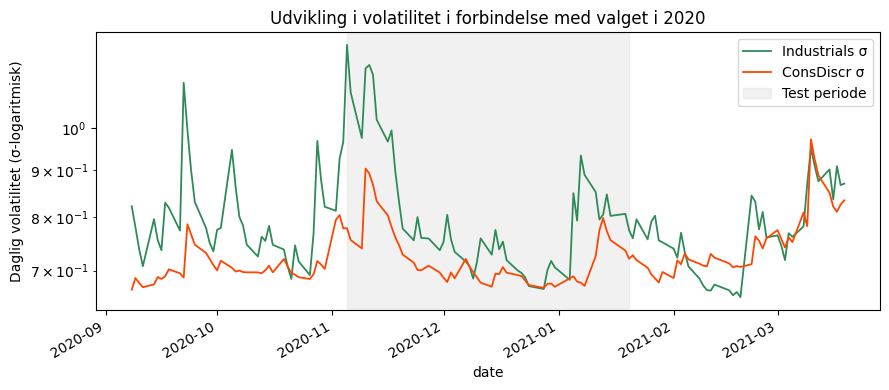

In [45]:
# ─── 1. locate the 2020 election row robustly ──────────────────────────
row2020 = cal[cal["call_date"].dt.year == 2020].iloc[0]
call_2020  = row2016["call_date"]
inaug_2021 = row2016["inaug_date"]

# ─── 2. build the 60-day-either-side window mask ───────────────────────
win_mask = (
    (resid_filled.index >= call_2016  - pd.Timedelta(days=60)) &
    (resid_filled.index <= inaug_2017 + pd.Timedelta(days=60))
)

# ─── 3. extract residuals for the two contrast sectors ─────────────────
tech_sig  = resid_filled.loc[win_mask, "Industrials"]
stap_sig  = resid_filled.loc[win_mask, "ConsDiscr"]


def cond_sigma(series):
    res = (
        arch_model(series, mean="Zero", vol="GARCH",
                   p=1, q=1, dist="normal")
        .fit(disp="off")
    )
    return res.conditional_volatility

sig_tech = cond_sigma(tech_sig)
sig_stap = cond_sigma(stap_sig)

# ─── 4. plot σₜ paths with shaded transition window ────────────────────
fig, ax = plt.subplots(figsize=(9, 4))
sig_tech.plot(ax=ax, logy=True, lw=1.3, color="seagreen",
              label="Industrials σ")
sig_stap.plot(ax=ax, logy=True, lw=1.3, color="orangered",
              label="ConsDiscr σ")

ax.axvspan(call_2016, inaug_2017,
           color="lightgrey", alpha=0.3,
           label="Test periode")

ax.set_ylabel("Daglig volatilitet (σ-logaritmisk)")
ax.set_title("Udvikling i volatilitet i forbindelse med valget i 2020")
ax.legend()
plt.tight_layout()

fig.savefig("udvikling_vola.png", dpi=300, bbox_inches="tight")
from google.colab import files
files.download("udvikling_vola.png")

plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

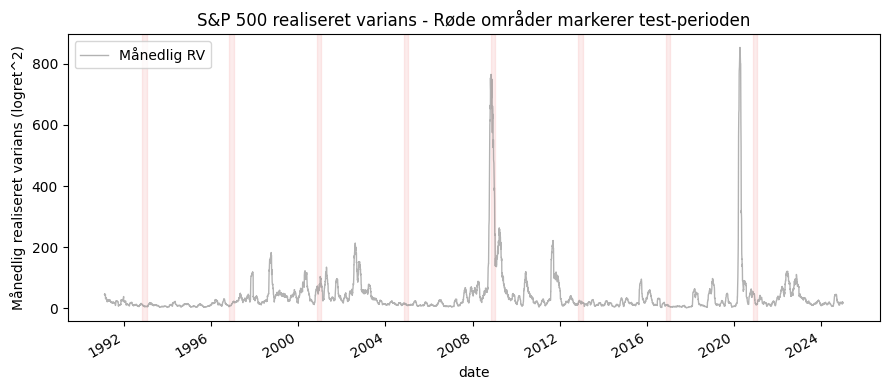

In [49]:
# ---- Figure 4   -------------------------------------------------

spx_excess = excess["SPX_logret_ret"]
spx_rv = spx_excess.rolling(30).apply(lambda x: np.nansum(x**2))

fig, ax = plt.subplots(figsize=(9,4))
spx_rv.plot(ax=ax, color="grey", alpha=0.6, lw=1, label="Månedlig RV")

for _, row in cal.iterrows():
    ax.axvspan(row.call_date, row.inaug_date,
               color="lightcoral", alpha=0.15)

ax.set_ylabel("Månedlig realiseret varians (logret^2)")
ax.set_title("S&P 500 realiseret varians - Røde områder markerer test-perioden")
ax.legend()
plt.tight_layout()

fig.savefig("bigplot.png", dpi=300, bbox_inches="tight")
from google.colab import files
files.download("bigplot.png")

plt.show()

